In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

df = pd.read_excel('Online Retail.xlsx')



df.dropna(subset=['CustomerID'], inplace=True)


df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]



df['CustomerID'] = df['CustomerID'].astype(int)

print("Data shape after cleaning:", df.shape)
df.info()

Data shape after cleaning: (397884, 8)
<class 'pandas.core.frame.DataFrame'>
Index: 397884 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  int32         
 7   Country      397884 non-null  object        
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(4)
memory usage: 25.8+ MB


In [2]:

df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)


rfm_data = df.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days, 
    'InvoiceNo': 'nunique',                                  
    'TotalPrice': 'sum'                                      
})


rfm_data.rename(columns={'InvoiceDate': 'Recency',
                         'InvoiceNo': 'Frequency',
                         'TotalPrice': 'MonetaryValue'}, inplace=True)

print("RFM Data Head:")
print(rfm_data.head())

RFM Data Head:
            Recency  Frequency  MonetaryValue
CustomerID                                   
12346           326          1       77183.60
12347             2          7        4310.00
12348            75          4        1797.24
12349            19          1        1757.55
12350           310          1         334.40


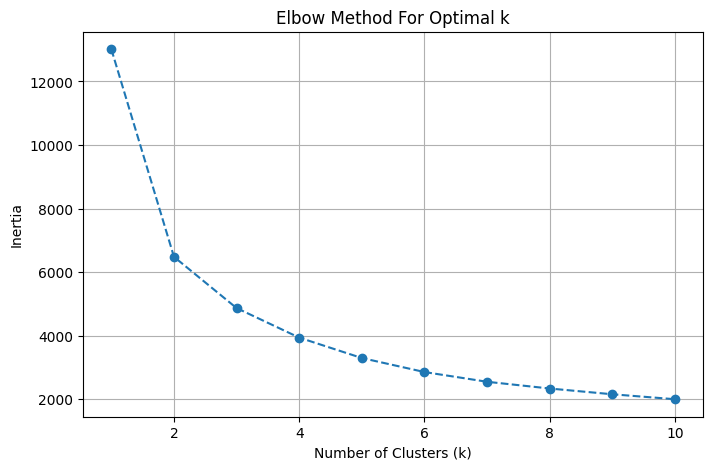


RFM Data with Cluster Labels:
            Recency  Frequency  MonetaryValue  Cluster
CustomerID                                            
12346           326          1       77183.60        2
12347             2          7        4310.00        1
12348            75          4        1797.24        2
12349            19          1        1757.55        0
12350           310          1         334.40        3


In [3]:

rfm_log = np.log1p(rfm_data)


scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)


rfm_scaled = pd.DataFrame(rfm_scaled, index=rfm_data.index, columns=rfm_data.columns)


inertia_list = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    inertia_list.append(kmeans.inertia_)


plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia_list, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


kmeans_model = KMeans(n_clusters=4, random_state=42, n_init=10)
cluster_labels = kmeans_model.fit_predict(rfm_scaled)


rfm_data['Cluster'] = cluster_labels

print("\nRFM Data with Cluster Labels:")
print(rfm_data.head())


Cluster Profile (Mean RFM Values):
         Recency  Frequency  MonetaryValue
Cluster                                   
0          18.12       2.15         551.82
1          12.13      13.71        8074.27
2          71.08       4.08        1802.83
3         182.50       1.32         343.45


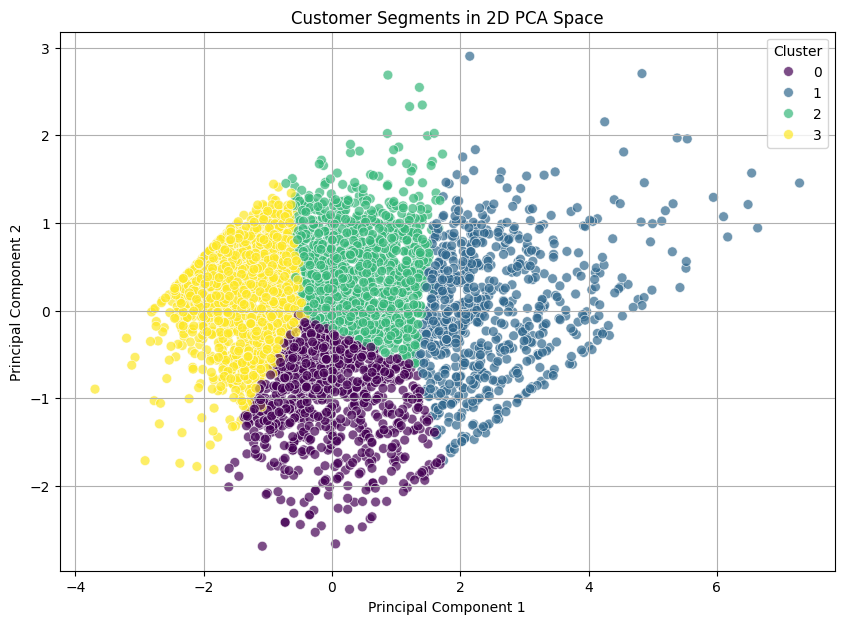

In [4]:

cluster_profile = rfm_data.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': 'mean'
}).round(2)

print("\nCluster Profile (Mean RFM Values):")
print(cluster_profile)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(rfm_scaled)


pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['Cluster'] = rfm_data['Cluster'].values


plt.figure(figsize=(10, 7))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis', s=50, alpha=0.7)
plt.title('Customer Segments in 2D PCA Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()